In [216]:
import pandas as pd
from nltk.corpus import stopwords
import string
import re
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
 df = pd.read_csv("youtube.csv" ,header=None ,encoding = 'ISO-8859-1')

In [4]:
df.columns = ["Video id " ,"Title" , "Description" , "Category"]

In [6]:
df.head()

,Video id,Title,Description,Category
0,13E5azGDK1k,FINE ART Music and Painting PEACEFUL SELECTION...,CALM MELODIES AND BEAUTIFUL PICTURESDebussy M...,Art and Music
1,tsKlRF2Gw1s,The Great Masterpieces of Art & Music,Skip the art museum and come experience Great...,Art and Music
2,rrJbuF6zOIk,babyfirst art and music,NaN,Art and Music
3,5mWjq2BsD9Q,Improvised Piano Music and Emotional Art Thera...,When watching this special episode of The Perf...,Art and Music
4,x7HPg9eZRY0,Sanjeev Abhyankar | Rakesh Chaurasia | Hindust...,Sanjeev Abhyankar and Rakesh Chaurasia rendere...,Art and Music


In [7]:
df["Description"].fillna(df["Title"] , inplace = True)  #filling nan values with same as title

In [10]:
def removeLinks(text):
    text = re.sub(r'<[^>]+>' , "" , text)  # remove any html tag in string
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)  # remove links from string
    text = re.sub(r'\S*@\S*\s?' , "" , text) # remove email addresses from string
    return text
df['Description'] = df['Description'].apply(removeLinks)

In [12]:
stop = stopwords.words('english')
pun = list(string.punctuation)

In [13]:
stop = stop + pun

In [18]:
# removing individual punctuation symbols and stop words
def removestop(text):
    text = text.split()
    l = [word.lower() for word in text if word.lower() not in stop]
    return " ".join(l)
df['Description'] = df['Description'].apply(removestop)

In [80]:
# removing all punctuation symbols that come in between words like: hell?heaven
def removepun(text):
    text = text.split(" ")
    li = []
    for word in text:
        for i in word:
            if i in pun:
                word = word.replace(i , "")
        li.append(word)
    return " ".join(li)
df['Description'] = df['Description'].apply(removepun)

In [177]:
x_train , x_test , y_train , y_test =train_test_split(df.iloc[0: , 0:3] , df.iloc[0:,3:4] , test_size = 0.1 , random_state = 0)

In [154]:
print(x_train.shape , x_test.shape , y_train.shape , y_test.shape)

(2456, 3) (273, 3) (2456, 1) (273, 1)


In [178]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(max_features=3500)

train_features = v.fit_transform(x_train['Description'])
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
test_features = v.transform(x_test['Description'])

C:\Users\sssha\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Category 1 Naive Bayes


In [182]:
from sklearn.naive_bayes import MultinomialNB
multinomial = MultinomialNB()
multinomial.fit(train_features, y_train)
multinomial.score(test_features, y_test)

0.8058608058608059

# Category 2 boosting models 

In [184]:
from sklearn.ensemble import GradientBoostingClassifier
gradient=GradientBoostingClassifier(n_estimators=100,random_state=0,learning_rate=0.1)
gradient.fit(train_features, y_train)
gradient.score(test_features, y_test)

0.8571428571428571

In [185]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

C:\Users\sssha\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [200]:
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(3500, 100, input_length=3500))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(100))
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model_conv
model_conv = create_conv_model()
model_conv.fit(train_features, y_train, validation_split=0.4, epochs = 3)

Train on 1473 samples, validate on 983 samples
Epoch 1/3
1473/1473 [==============================] - 670s 455ms/step - loss: -12.7399 - acc: 0.1270 - val_loss: -21.2133 - val_acc: 0.1292
Epoch 2/3
1473/1473 [==============================] - 675s 458ms/step - loss: -21.3106 - acc: 0.1270 - val_loss: -21.2133 - val_acc: 0.1292
Epoch 3/3
1473/1473 [==============================] - 710s 482ms/step - loss: -21.3106 - acc: 0.1270 - val_loss: -21.2133 - val_acc: 0.1292


#  precision, recall, and F1 Score

In [201]:
from sklearn.metrics import recall_score,precision_score,f1_score

In [204]:
y_multinomial = multinomial.predict(test_features)
y_gradient = gradient.predict(test_features)

In [206]:
multinomial_recall = recall_score(y_test,y_multinomial,average='micro')
multinomial_precision = precision_score(y_test,y_multinomial,average='micro')
multinomial_f1 = f1_score(y_test,y_multinomial,average='micro')

In [208]:
gradient_recall = recall_score(y_test,y_gradient,average='micro')
gradient_precision = precision_score(y_test,y_gradient,average='micro')
gradient_f1 = f1_score(y_test,y_gradient,average='micro')

In [209]:
data = [[multinomial_recall,multinomial_precision,multinomial_f1,'Multinomial Naive bayes'],[gradient_recall,gradient_precision,gradient_f1,'bagging']]
df = pd.DataFrame(data,columns=['Precision','Recall','f1-score','Model'])

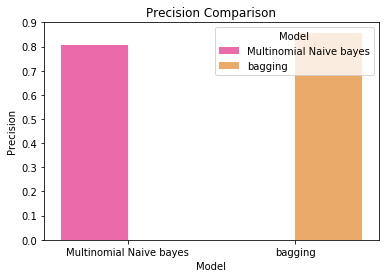

In [223]:
sns.barplot(y='Precision',x='Model',data=df , palette = "spring" , hue = "Model")
plt.title('Precision Comparison')
f = plt.gcf()

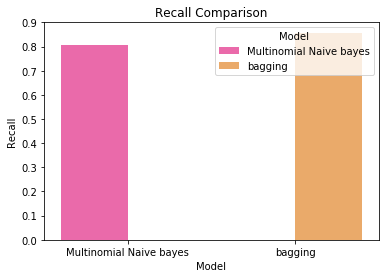

In [225]:
sns.barplot(y='Recall',x='Model',data=df , palette = "spring" , hue = "Model")
plt.title('Recall Comparison')
f = plt.gcf()

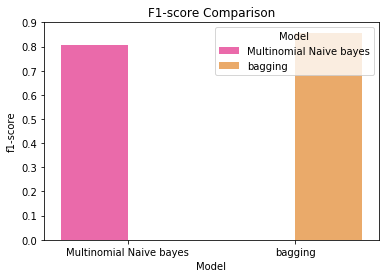

In [227]:
sns.barplot(y='f1-score',x='Model',data=df , palette = "spring" , hue = "Model")
plt.title('F1-score Comparison')
f = plt.gcf()